In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist, fashion_mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Reshape, UpSampling2D
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K
from keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
import imageio.v3 as iio
import os
import shutil
from glob import glob
from sklearn.model_selection import GridSearchCV
from PIL import Image
from tqdm import tqdm

In [2]:
(x_minst_train, y_minst_train), (x_minst_test, y_minst_test) = mnist.load_data()
assert x_minst_train.shape == (60000, 28, 28)
assert x_minst_test.shape == (10000, 28, 28)
assert y_minst_train.shape == (60000,)
assert y_minst_test.shape == (10000,)

x_minst_train, x_minst_test = x_minst_train / 255.0, x_minst_test / 255.0
x_minst_train = x_minst_train.reshape(x_minst_train.shape[0], 28, 28, 1)
x_minst_test = x_minst_test.reshape(x_minst_test.shape[0], 28, 28, 1)

x_minst_train, x_minst_val, y_minst_train, y_minst_val = train_test_split(x_minst_train, y_minst_train, test_size=0.25)

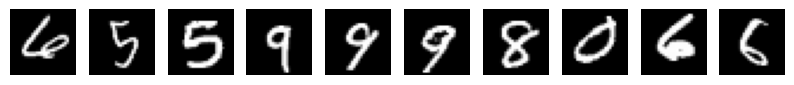

In [3]:
fig, axes = plt.subplots(1, 10, figsize=(10, 1))
for i, ax in enumerate(axes):
    ax.imshow(x_minst_train[i], cmap="gray")
    ax.axis("off")

In [4]:
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()
assert x_fashion_train.shape == (60000, 28, 28)
assert x_fashion_test.shape == (10000, 28, 28)
assert y_fashion_train.shape == (60000,)
assert y_fashion_test.shape == (10000,)

x_fashion_train, x_fashion_test = x_fashion_train / 255.0, x_fashion_test / 255.0
x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], 28, 28, 1)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], 28, 28, 1)

x_fashion_train, x_fashion_val, y_fashion_train, y_fashion_val = train_test_split(x_fashion_train, y_fashion_train, test_size=0.25)

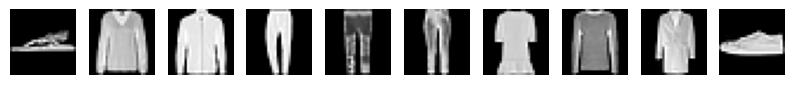

In [5]:
fig, axes = plt.subplots(1, 10, figsize=(10, 1))
for i, ax in enumerate(axes):
    ax.imshow(x_fashion_train[i], cmap="gray")
    ax.axis("off")

In [6]:
def create_encoder(input_shape, latent_dim):
    encoder = Sequential([
        Conv2D(64, 3, activation="relu", padding="same", input_shape=input_shape),
        Conv2D(64, 3, activation="relu", padding="same"),
        MaxPooling2D(2),
        BatchNormalization(),
        
        Conv2D(64, 3, activation="relu", padding="same"),
        Conv2D(64, 3, activation="relu", padding="same"),
        MaxPooling2D(2),
        BatchNormalization(),
        
        Conv2D(32, 3, activation="relu", padding="same"),
        Conv2D(32, 3, activation="relu", padding="same"),
        MaxPooling2D(2),
        BatchNormalization(),
        
        Flatten(),
        Dense(latent_dim, activation="relu")
    ])
    return encoder

In [7]:
def create_decoder(output_shape, latent_dim):
    decoder = Sequential([
        Dense(3*3*32, activation="relu", input_shape=(latent_dim,)),
        Reshape((3, 3, 32)),
        
        UpSampling2D(2),
        Conv2D(32, 3, activation="relu", padding="same"),
        Conv2D(32, 3, activation="relu", padding="same"),
        
        UpSampling2D(2),
        Conv2D(64, 3, activation="relu", padding="same"),
        Conv2D(64, 3, activation="relu", padding="same"),
        
        UpSampling2D(2),
        Conv2D(64, 3, activation="relu", padding="same"),
        Conv2D(64, 3, activation="relu", padding="same"),
        
        Conv2D(1, 3, activation="sigmoid", padding="same")
    ])
    return decoder

In [8]:
def create_model(input_shape, latent_dim):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = Conv2D(32, (2, 2), activation="relu", padding="same")(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(16, (2, 2), activation="relu", padding="same")(x)
    x = Conv2D(4, (2, 2), activation="relu", padding="same")(x)
    x = Conv2D(1, (2, 2), activation="relu", padding="same")(x)
    x = Flatten()(x)
    encoded = Dense(latent_dim, activation="relu")(x)

    encoder = Model(inputs=inputs, outputs=encoded)

    encoded_inputs = Input(shape=(latent_dim,))

    x = Dense(4, activation="relu")(encoded_inputs)
    x = Reshape((2, 2, 1))(x)
    x = Conv2D(4, (2, 2), activation="relu", padding="same")(x)
    x = Conv2D(16, (2, 2), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((7, 7))(x)
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
    decoded = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

    decoder = Model(inputs=encoded_inputs, outputs=decoded)

    x = encoder(inputs)
    x = decoder(x)
    model = Model(inputs=inputs, outputs=x)
    model.compile(
        optimizer=Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy", "mse"],
    )
    
    return model, encoder, decoder

In [9]:
# enc_minst = create_encoder(x_minst_train.shape[1:], latent_dim=6)
# dec_minst = create_decoder(x_minst_train.shape[1:], latent_dim=6)
# minst_model = Sequential([enc_minst, dec_minst])
# minst_model.compile(optimizer=Adam(0.001), loss="binary_crossentropy", metrics=["accuracy", "mse"])

In [10]:
minst_model, enc_minst, dec_minst = create_model(x_minst_train.shape[1:], latent_dim=6)
minst_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model (Functional)          (None, 6)                 35089     
                                                                 
 model_1 (Functional)        (None, 28, 28, 1)         42433     
                                                                 
Total params: 77,522
Trainable params: 77,298
Non-trainable params: 224
_________________________________________________________________


In [11]:
clr = ReduceLROnPlateau(
    monitor="loss",
    factor=0.5,
    patience=3,
    min_delta=0.01,
    cooldown=0,
    min_lr=1e-7,
    verbose=1,
)

In [12]:
minst_history = minst_model.fit(
    x_minst_train, x_minst_train,
    validation_data=(x_minst_val, x_minst_val),
    epochs=10,
    batch_size=256,
    callbacks=[clr],
)

Epoch 1/10
176/176 [==============================] - 17s 70ms/step - loss: 0.2434 - accuracy: 0.7977 - mse: 0.0616 - val_loss: 0.7165 - val_accuracy: 0.8088 - val_mse: 0.1098 - lr: 0.0010
Epoch 2/10
176/176 [==============================] - 15s 84ms/step - loss: 0.1907 - accuracy: 0.7946 - mse: 0.0439 - val_loss: 0.2960 - val_accuracy: 0.7989 - val_mse: 0.0705 - lr: 0.0010
Epoch 3/10
176/176 [==============================] - 15s 86ms/step - loss: 0.1763 - accuracy: 0.7977 - mse: 0.0386 - val_loss: 0.2112 - val_accuracy: 0.7922 - val_mse: 0.0502 - lr: 0.0010
Epoch 4/10
176/176 [==============================] - 14s 80ms/step - loss: 0.1707 - accuracy: 0.7991 - mse: 0.0366 - val_loss: 0.1841 - val_accuracy: 0.7980 - val_mse: 0.0409 - lr: 0.0010
Epoch 5/10
176/176 [==============================] - 14s 79ms/step - loss: 0.1677 - accuracy: 0.7999 - mse: 0.0355 - val_loss: 0.1724 - val_accuracy: 0.8035 - val_mse: 0.0369 - lr: 0.0010
Epoch 6/10
176/176 [==============================] - 1

In [21]:
import time
def get_sample_from_each_class(x, y):
    np.random.seed(int(time.time()))
    shuffled_idx = np.arange(len(y))
    np.random.shuffle(shuffled_idx)
    x = x[shuffled_idx]
    y = y[shuffled_idx]
    samples = []
    for i in range(10):
        idx = np.where(y == i)[0][0]
        samples.append(x[idx])
    return np.array(samples)

In [14]:
def get_triple(inputs, encoder, decoder):
    latent_repr = encoder.predict(inputs)
    outputs = decoder.predict(latent_repr)
    latent_repr = latent_repr.reshape((latent_repr.shape[0], latent_repr.shape[1], 1))

    return inputs, latent_repr, outputs


def show_encodings(inputs, latent_repr, outputs):
    n = len(inputs)
    fig, axes = plt.subplots(2, n, figsize=(2 * n, 5))
    for i in range(n):
        axes[0, i].imshow(inputs[i].reshape(28, 28), cmap="gray")
        axes[1, i].imshow(outputs[i].reshape(28, 28), cmap="gray")
    for ax in axes.flatten():
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

1/1 [==============================] - 0s 19ms/step


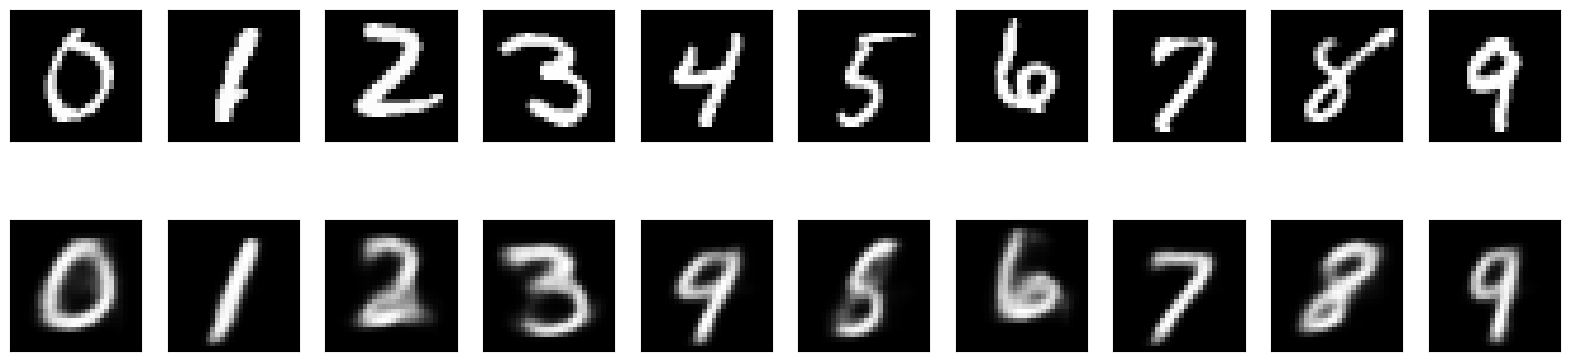

In [39]:
show_encodings(*get_triple(get_sample_from_each_class(x_minst_test, y_minst_test), enc_minst, dec_minst))

In [16]:
fashion_minst_model, enc_fashion_minst, dec_fashion_minst = create_model(x_fashion_train.shape[1:], latent_dim=6)
fashion_minst_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model_3 (Functional)        (None, 6)                 35089     
                                                                 
 model_4 (Functional)        (None, 28, 28, 1)         42433     
                                                                 
Total params: 77,522
Trainable params: 77,298
Non-trainable params: 224
_________________________________________________________________


In [17]:
fashion_mnist_history = fashion_minst_model.fit(
    x_fashion_train, x_fashion_train,
    validation_data=(x_fashion_val, x_fashion_val),
    epochs=10,
    batch_size=256,
)

Epoch 1/10
176/176 [==============================] - 23s 125ms/step - loss: 0.3882 - accuracy: 0.4915 - mse: 0.0493 - val_loss: 0.9968 - val_accuracy: 0.5019 - val_mse: 0.1831
Epoch 2/10
176/176 [==============================] - 28s 156ms/step - loss: 0.3418 - accuracy: 0.4973 - mse: 0.0341 - val_loss: 0.6671 - val_accuracy: 0.5004 - val_mse: 0.1199
Epoch 3/10
176/176 [==============================] - 19s 108ms/step - loss: 0.3343 - accuracy: 0.4983 - mse: 0.0317 - val_loss: 0.4004 - val_accuracy: 0.5013 - val_mse: 0.0533
Epoch 4/10
176/176 [==============================] - 20s 113ms/step - loss: 0.3315 - accuracy: 0.4986 - mse: 0.0309 - val_loss: 0.3379 - val_accuracy: 0.4989 - val_mse: 0.0334
Epoch 5/10
176/176 [==============================] - 27s 149ms/step - loss: 0.3288 - accuracy: 0.4990 - mse: 0.0300 - val_loss: 0.3302 - val_accuracy: 0.4998 - val_mse: 0.0305
Epoch 6/10
176/176 [==============================] - 24s 135ms/step - loss: 0.3270 - accuracy: 0.4992 - mse: 0.029

1/1 [==============================] - 0s 25ms/step


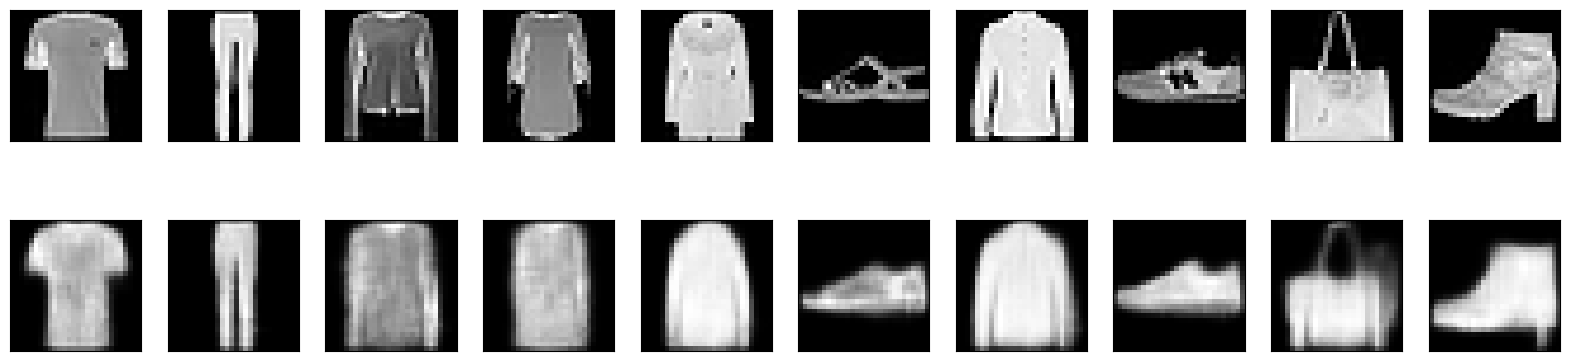

In [43]:
show_encodings(*get_triple(get_sample_from_each_class(x_fashion_test, y_fashion_test), enc_fashion_minst, dec_fashion_minst))

In [44]:
minst_model.save_weights("../models/minst_autoencoder.h5")
fashion_minst_model.save_weights("../models/fashion_minst_autoencoder.h5")